In [1]:
RAND_STATE = 42

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../saved/final_dataset_cs_papers_last_20.csv", index_col='PaperId')

In [3]:
normalized_cc = df["CitationCountPerYear"].values
normalized_cc.shape

(61019,)

In [4]:
print(f"Max number of citations per year: {np.max(normalized_cc)}")
print(f"Median number of citations per year: {np.median(normalized_cc)}")
print(f"Mean number of citations per year: {np.mean(normalized_cc)}")
print(f"Std number of citations per year: {np.std(normalized_cc)}")

print(f"Number of papers with 0 citations: {np.sum((normalized_cc == 0))}")
print(f"Number papers with over 1 citation per year: {np.sum(normalized_cc > 1)}")
print(f"Number papers with over 5 citations per year: {np.sum(normalized_cc > 5)}")
print(f"Number papers with over 25 citations per year: {np.sum(normalized_cc > 25)}")
print(f"Number papers with over 100 citations per year: {np.sum(normalized_cc > 100)}")
print(f"Number papers with over 1k citations per year: {np.sum(normalized_cc > 1000)}")


Max number of citations per year: 1143.3305548940225
Median number of citations per year: 0.6211003970504821
Mean number of citations per year: 2.8393615494580478
Std number of citations per year: 12.939019144245327
Number of papers with 0 citations: 10686
Number papers with over 1 citation per year: 23794
Number papers with over 5 citations per year: 7443
Number papers with over 25 citations per year: 936
Number papers with over 100 citations per year: 123
Number papers with over 1k citations per year: 1


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd7a0bbafa0>,
                 k=None, locate_elbow=True, metric='distortion', model=None,
                 timings=True)

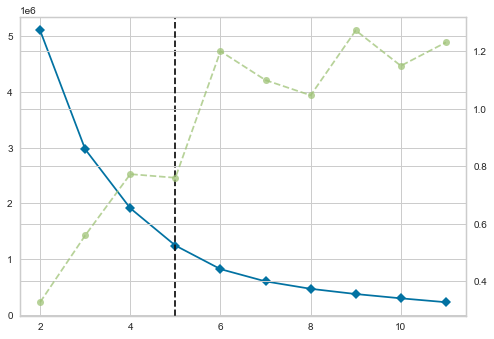

In [5]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))
visualizer.fit(normalized_cc.reshape(-1, 1))

In [6]:
clstr = KMeans(n_clusters=4, random_state=0)
clstr.fit(normalized_cc.reshape(-1,1))
clstr.cluster_centers_

array([[ 29.26362672],
       [  1.58320266],
       [161.81378789],
       [576.03412154]])

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4, random_state=0)
gmm.fit(normalized_cc.reshape(-1,1))
gmm.means_

array([[ 0.17034089],
       [49.67828457],
       [ 6.83178226],
       [ 1.1702358 ]])

In [8]:
def custom_binning(x, thresholds):
    thresholds = thresholds.copy()
    thresholds.sort()
    for i, threshold in enumerate(thresholds):
        if (x <= threshold):
            return i + 1

    return len(thresholds)


In [9]:
thresholds = np.array([mu + np.sqrt(var).round() for mu, var in zip(gmm.means_, gmm.covariances_)]).flatten()
thresholds.sort()
n_classes = len(thresholds)
print(thresholds)
df["BinnedCitations"] = pd.Series([custom_binning(x, thresholds) for x in normalized_cc], index=df.index)
df.head()

[  0.17034089   2.1702358   10.83178226 118.67828457]


,Abstract,Author_1,Author_10,Author_11,Author_2,Author_3,Author_4,Author_5,Author_6,Author_7,...,MagBin,CitationBin,AuthorRank,JournalNameRank,PublisherRank,PageCount,Processed_Abstract,JournalNameRankNormalized,PublisherRankNormalized,BinnedCitations
PaperId,,,,,,,,,,,,,,,,,,,,,
2013266033,Two important automation characteristics are c...,1976502312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,above-average,below-average,1.0,980.0,596.0,9.0,important automation characteristic crucial co...,1319.0,479.0,2
2147483915,Many Internet of Things (IoT) technologies h...,2141485328,NaN,NaN,2.713835e+09,2.226086e+09,2.224880e+09,2.231733e+09,NaN,NaN,...,low,high,1372.0,502.0,627.0,10.0,many internet things iot technology use applic...,1243.0,478.0,3
2147483970,This paper deals with an application of wavele...,2275778229,NaN,NaN,2.779769e+09,1.355326e+09,2.095098e+09,NaN,NaN,NaN,...,below-average,above-average,128.0,993.0,624.0,14.0,this paper deal application wavelet feature ex...,888.0,363.0,2
2013266260,An object-to-object color mapping method based...,2135137024,NaN,NaN,2.131763e+09,2.106423e+09,NaN,NaN,NaN,NaN,...,above-average,below-average,127.0,759.0,585.0,10.0,an object object color map method base image s...,624.0,303.0,1
2013266632,"We present a distributed, integrated medium ac...",2304913869,NaN,NaN,2.124193e+09,2.030774e+09,2.091976e+08,4.341810e+08,NaN,NaN,...,low,high,1112.0,995.0,627.0,10.0,we present distribute integrate medium access ...,1183.0,478.0,3


[16171, 31419, 10255, 3174]


([<matplotlib.axis.XTick at 0x7fd7b2703100>,
 <a list of 4 Text major ticklabel objects>)

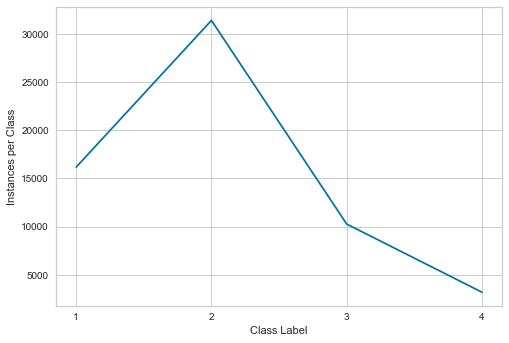

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

classes = list(range(1, 1 + n_classes))

x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x)
fig = plt.figure()
plt.plot(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

## Convert to binary classification

In [11]:
classes = [0, 1]
n_classes = 2

df["BinnedCitations"][df["BinnedCitations"] == 1] = 0
df["BinnedCitations"][df["BinnedCitations"] == 2] = 1
df["BinnedCitations"][df["BinnedCitations"] == 3] = 1
df["BinnedCitations"][df["BinnedCitations"] == 4] = 1

[16171, 44848] [0, 1]


([<matplotlib.axis.XTick at 0x7fd7a0bf12b0>,
 <a list of 2 Text major ticklabel objects>)

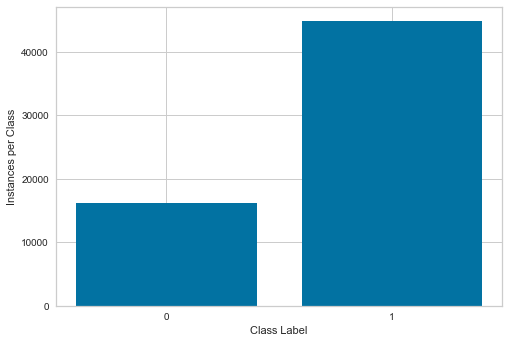

In [12]:
x = [np.sum(df.loc[:, "BinnedCitations"].values == c) for c in classes]
print(x, classes)
fig = plt.figure()
plt.bar(classes, x)
plt.ylabel("Instances per Class")
plt.xlabel("Class Label")
plt.xticks(classes)

In [36]:
from sklearn.metrics import classification_report
features = [ 
    "AuthorProminence",
    "JournalNameRankNormalized",
    "PublisherRankNormalized",
    "AuthorRank",
    # "PageCount"
    ]
X = df.loc[:, features]
y = df.loc[:, "BinnedCitations"]

print(X.shape, y.shape)
print(classification_report(y, y))


(61019, 4) (61019,)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16171
           1       1.00      1.00      1.00     44848

    accuracy                           1.00     61019
   macro avg       1.00      1.00      1.00     61019
weighted avg       1.00      1.00      1.00     61019



# Data split into train, test, and dev

In [37]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.10, shuffle=True, random_state=RAND_STATE)

X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RAND_STATE)

print(X_train.shape)
print(X_dev.shape)
print(X_test.shape)

(46679, 4)
(8238, 4)
(6102, 4)


In [38]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=RAND_STATE, n_estimators=1000, max_depth=3, learning_rate=0.01, gamma=5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
from sklearn.metrics import confusion_matrix

y_true = y_dev
y_pred = xgb.predict(X_dev)

print(confusion_matrix(y_true, y_pred, labels=classes))
print(classification_report(y_true, y_pred))
print("Train performance")
print(xgb.score(X_train, y_train))
print("Dev performance")
print(xgb.score(X_dev, y_dev))

[[1028 1169]
 [ 430 5611]]
              precision    recall  f1-score   support

           0       0.71      0.47      0.56      2197
           1       0.83      0.93      0.88      6041

    accuracy                           0.81      8238
   macro avg       0.77      0.70      0.72      8238
weighted avg       0.79      0.81      0.79      8238

Train performance
0.8078150774438184
Dev performance
0.8058994901675164


In [35]:
def df_from_predictions(paper_ids, y_pred, original_df):
    pred_df = pd.DataFrame(
        list(zip(paper_ids, y_pred)),
        columns=["PaperId", "PredictedBinnedCitations"]
    ).set_index("PaperId")
    pred_df = pred_df.join(original_df, on='PaperId')
    pred_df["Misclassified"] = pred_df.apply(lambda x: 1 if x["PredictedBinnedCitations"] != x["BinnedCitations"] else 0, axis=1)
    pred_df["MisclassifiedAsHigh"] = pred_df.apply(
        lambda x: 1 if x["PredictedBinnedCitations"] and x["Misclassified"] else 0, 
        axis=1
    )
    pred_df["MisclassifiedAsLow"] = pred_df.apply(
        lambda x: 1 if x["PredictedBinnedCitations"]== 0 and x["Misclassified"] else 0, 
        axis=1
    )

    return pred_df

train_predictions_df = df_from_predictions(X_train.index, xgb.predict(X_train), df)

In [20]:
train_predictions_df.to_csv("../saved/xgb_predictions_train.csv", index_label="PaperId")